# Project MTI865 - Heart segmentation using UNet 

## Import libraries

In [28]:
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import v2
from progressBar import printProgressBar

import medicalDataLoader
import argparse
import utils

from UNet_Base import *
import random
import torch
import pdb
import matplotlib.pyplot as plt
import numpy as np
import os

In [29]:
import warnings
warnings.filterwarnings("ignore")

## Loading data 

In [30]:
batch_size = 2
batch_size_val = 4
batch_size_unlabel = 8

In [31]:
# Define image and mask transformations
transform = v2.Compose([
    v2.ToTensor()
])

mask_transform = v2.Compose([
    v2.ToTensor()
])

In [33]:
def collate_fn(batch):
    imgs = []
    masks = []
    img_paths = []

    for item in batch:
        img, mask, img_path = item[0], item[1], item[2]
        imgs.append(img)
        img_paths.append(img_path)
        
        # Si le masque est None, ajouter un tenseur de zéros correspondant à sa taille
        if mask is not None:
            masks.append(mask)
        else:
            masks.append(torch.zeros_like(img[0, :, :]))  # Même taille que le canal de l'image (assumant CxHxW)

    # Stack les images et les masques
    imgs_tensor = torch.stack(imgs)  # Tensor de forme (B, C, H, W)
    masks_tensor = torch.stack(masks)  # Tensor de forme (B, H, W)

    return imgs_tensor, masks_tensor, img_paths



In [37]:
# Define dataloaders
root_dir = './data/'
print(' Dataset: {} '.format(root_dir))

supervised_set = medicalDataLoader.MedicalImageDataset('train',
                                                    root_dir,
                                                    transform=transform,
                                                    mask_transform=mask_transform,
                                                    augment=True,
                                                    equalize=False)


supervised_loader = DataLoader(
    supervised_set,
    batch_size=batch_size,
    worker_init_fn=np.random.seed(0),
    num_workers=0,
    shuffle=True,
    collate_fn=collate_fn)


val_set = medicalDataLoader.MedicalImageDataset('val',
                                                root_dir,
                                                transform=transform,
                                                mask_transform=mask_transform,
                                                equalize=False)

val_loader = DataLoader(val_set,
                        batch_size=batch_size_val,
                        worker_init_fn=np.random.seed(0),
                        num_workers=0,
                        shuffle=False)

unsupervised_set = medicalDataLoader.MedicalImageDataset('train-unlabelled',
                                                            root_dir,
                                                            transform=transform,
                                                            mask_transform=mask_transform,
                                                            augment=False,
                                                            equalize=False)
# print(train_unlabelled_set.imgs)
# train_unlabelled_set = [(img) for img, mask in train_unlabelled_set]
unsupervised_loader = DataLoader(unsupervised_set,
                                    batch_size=batch_size_unlabel,
                                    worker_init_fn=np.random.seed(0),
                                    num_workers=0,
                                    shuffle=False,
                                    collate_fn=collate_fn)



print('Train set: ', len(supervised_set))
print('Validation set: ', len(val_set))

n_train_label = len(supervised_set)
n_train_unlabel = len(unsupervised_set)

# shape of the image a  nd mask
img, mask, _ = supervised_set[0]
print('Image shape: ', img.shape)
print('Mask shape: ', mask.shape)
print('Number of batches: ', len(supervised_loader))

img, mask, _ = val_set[0]
print('Image shape: ', img.shape)
print('Mask shape: ', mask.shape)
print('Number of batches: ', len(val_loader))

img, _, __ = unsupervised_set[0]
print('Image shape: ', img.shape)
print('Mask shape: ', mask.shape)
print('Number of batches: ', len(unsupervised_loader))


print('First of the supervised set')
img, mask, path_tuple = supervised_set[0]
print(img)
print(mask)
print(path_tuple)

print('First of the unsupervised set')
img, mask, path_tuple = unsupervised_set[0]
print(img)
print(mask)
print(path_tuple)




 Dataset: ./data/ 
Found 204 items in train
First item:  ('./data/train\\Img\\patient006_01_1.png', './data/train\\GT\\patient006_01_1.png')
Found 74 items in val
First item:  ('./data/val\\Img\\patient001_01_1.png', './data/val\\GT\\patient001_01_1.png')
Found 1004 items in train-unlabelled
First item:  ('./data/train\\Img-Unlabeled\\patient007_01_1.png', None)
Train set:  204
Validation set:  74
Image shape:  torch.Size([1, 256, 256])
Mask shape:  torch.Size([1, 256, 256])
Number of batches:  102
Image shape:  torch.Size([1, 256, 256])
Mask shape:  torch.Size([1, 256, 256])
Number of batches:  19
Image shape:  torch.Size([1, 256, 256])
Mask shape:  torch.Size([1, 256, 256])
Number of batches:  126
First of the supervised set
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
t

(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]]), tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
   

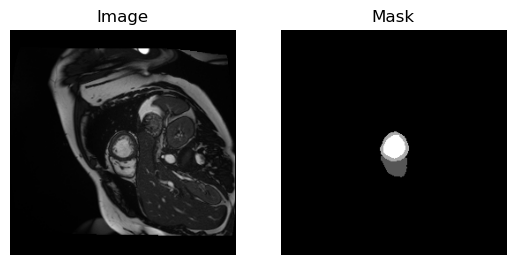

Done!


In [24]:
for sample in supervised_loader:
    images, masks, _ = sample
    print(sample)
    print('Image batch dimensions: ', images.size())
    print('Mask batch dimensions: ', masks.size())
    
    # Show first image and mask
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(images[0,0,:,:], cmap='gray')
    plt.title('Image')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(masks[0,0,:,:], cmap='gray')
    plt.title('Mask')
    plt.axis('off')
    plt.show()

    break
print('Done!')


(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0

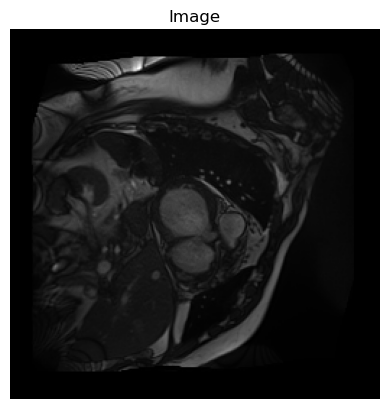

0


In [26]:
for i, sample in enumerate(unsupervised_loader):
    print(sample )
    images, maskNone, _ = sample
    print('Image batch dimensions: ', images.size())
    # print('Mask batch dimensions: ', masks.size())
    
    # Show first image and mask
    if i <= 5:
        
        plt.figure()
        # plt.subplot(1,2,1)
        plt.imshow(images[0,0,:,:], cmap='gray')
        plt.title('Image')
        plt.axis('off')
        # plt.subplot(1,2,2)

        # plt.imshow(masks[0,0,:,:], cmap='gray')
        # plt.title('Mask')
        # plt.axis('off')
        plt.show()
        break
    # break
print(i)

## Modèle basique : Entraînement avec les GT uniquement 

### Paramètres de l'entraînement

In [27]:
# Define hyperparameters

lr =  0.001    # Learning Rate
total_epochs = 30  # Number of epochs

### Entraînement du modèle 

In [ ]:
def runTraining(writer: SummaryWriter):
    print("-" * 40)
    print("~~~~~~~~  Starting the training... ~~~~~~")
    print("-" * 40)

    num_classes = 4

    # Set device depending on the availability of GPU
    if torch.cuda.is_available():
        device = torch.device("cuda")
    # elif torch.mps.is_available():  # Apple M-series of chips
    #     device = torch.device("mps")
    else:
        device = torch.device("cpu")

    print(f"Using device: {device}")

    print("~~~~~~~~~~~ Creating the UNet model ~~~~~~~~~~")
    modelName = "Test_Model"
    print(" Model Name: {}".format(modelName))

    ## CREATION OF YOUR MODEL
    net = UNet(num_classes).to(device)

    print(
        "Total params: {0:,}".format(
            sum(p.numel() for p in net.parameters() if p.requires_grad)
        )
    )

    # DEFINE YOUR OUTPUT COMPONENTS (e.g., SOFTMAX, LOSS FUNCTION, ETC)
    softMax = torch.nn.Softmax(dim=1)
    CE_loss = torch.nn.CrossEntropyLoss()

    ## PUT EVERYTHING IN GPU RESOURCES
    # if torch.cuda.is_available():
    #     net.cuda()
    #     softMax.cuda()
    #     CE_loss.cuda()

    ## DEFINE YOUR OPTIMIZER
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=1e-5)

    ### To save statistics ####
    train_losses = []
    train_dc_losses = []
    val_losses = []
    val_dc_losses = []

    best_loss_val = 1000

    directory = "Results/Statistics/" + modelName

    print("~~~~~~~~~~~ Starting the training ~~~~~~~~~~")
    if os.path.exists(directory) == False:
        os.makedirs(directory)

    ## START THE TRAINING

    ## FOR EACH EPOCH
    for epoch in range(total_epochs):
        net.train()

        num_batches = len(supervised_loader)
        print("Number of batches: ", num_batches)

        running_train_loss = 0
        running_dice_loss = 0

        # Training loop
        for idx, data in enumerate(supervised_loader):
            ### Set to zero all the gradients
            net.zero_grad()
            optimizer.zero_grad()

            ## GET IMAGES, LABELS and IMG NAMES
            images, labels, img_names = data
            print("Type of labels before to_var:", type(labels))
            ### From numpy to torch variables
            labels = utils.to_var(labels).to(device)
            images = utils.to_var(images).to(device)

            # Forward pass
            net_predictions = net(images)

            # Get the segmentation classes
            segmentation_classes = utils.getTargetSegmentation(labels)

            # Compute the loss
            loss = CE_loss(net_predictions, segmentation_classes)
            running_train_loss += loss.item()
            # dice_loss = dice_coefficient(net_predictions, labels)
            dice_loss = utils.compute_dsc(net_predictions, labels)
            running_dice_loss += dice_loss

            # Backprop
            loss.backward()
            optimizer.step()

            # Add the loss to the tensorboard every 5 batches
            if idx % 10 == 0:
                writer.add_scalar(
                    "Loss/train", running_train_loss / (idx + 1), epoch * len(supervised_loader) + idx
                )
                writer.add_scalar(
                    "Dice/train", running_dice_loss / (idx + 1), epoch * len(supervised_loader) + idx
                )

            if idx % 100 == 0:
                # Also add visualizations of the images
                probs = torch.softmax(net_predictions, dim=1)
                y_pred = torch.argmax(probs, dim=1)
                writer.add_figure('predictions vs. actuals',
                            utils.plot_net_predictions(images, labels, y_pred, batch_size),
                            global_step=epoch * len(supervised_loader) + idx)

            # THIS IS JUST TO VISUALIZE THE TRAINING
            printProgressBar(
                idx + 1,
                num_batches,
                prefix="[Training] Epoch: {} ".format(epoch),
                length=15,
                suffix=" Loss: {:.4f}, ".format(running_train_loss / (idx + 1)),
            )

        train_loss = running_train_loss / num_batches
        train_losses.append(train_loss)

        train_dc_loss = running_dice_loss / num_batches
        train_dc_losses.append(train_dc_loss)

        net.eval()
        val_running_loss = 0
        val_running_dc = 0

        # Validation loop
        with torch.no_grad():
            for idx, data in enumerate(val_loader):
                images, labels, img_names = data

                labels = utils.to_var(labels).to(device)
                images = utils.to_var(images).to(device)

                net_predictions = net(images)

                segmentation_classes = utils.getTargetSegmentation(labels)

                loss = CE_loss(net_predictions, segmentation_classes) 
                val_running_loss += loss.item()

                # dice_loss = dice_coefficient(net_predictions, labels)
                dice_loss = utils.compute_dsc(net_predictions, labels)
                val_running_dc += dice_loss

                if idx % 10 == 0:
                    writer.add_scalar(
                        "Loss/val",
                        val_running_loss / (idx + 1),
                        epoch * len(val_loader) + idx,
                    )
                    writer.add_scalar(
                        "Dice/val",
                        val_running_dc / (idx + 1),
                        epoch * len(val_loader) + idx,
                    )

                printProgressBar(
                    idx + 1,
                    len(val_loader),
                    prefix="[Validation] Epoch: {} ".format(epoch),
                    length=15,
                    suffix=" Loss: {:.4f}, ".format(val_running_loss / (idx + 1)),
                )

        val_loss = val_running_loss / len(val_loader)
        val_losses.append(val_loss)
        dc_loss = val_running_dc / len(val_loader)
        val_dc_losses.append(dc_loss)

        # Check if model performed best and save it if true
        if val_loss < best_loss_val:
            best_loss_val = val_loss
            if not os.path.exists("./models/" + modelName):
                os.makedirs("./models/" + modelName)
            torch.save(
                net.state_dict(), "./models/" + modelName + "/" + str(epoch) + "_Epoch"
            )

        printProgressBar(
            num_batches,
            num_batches,
            done="[Epoch: {}, TrainLoss: {:.4f}, TrainDice: {:.4f}, ValLoss: {:.4f}".format(
                epoch, train_loss, train_dc_loss, val_loss
            ),
        )

        np.save(os.path.join(directory, "Losses.npy"), train_losses)
    writer.flush()  # Flush the writer to ensure that all the data is written to disk

In [20]:
# Set up Tensorboard writer
writer = SummaryWriter()
runTraining(writer)
writer.close()

----------------------------------------
~~~~~~~~  Starting the training... ~~~~~~
----------------------------------------
Using device: cpu
~~~~~~~~~~~ Creating the UNet model ~~~~~~~~~~
 Model Name: Test_Model
Total params: 60,664
~~~~~~~~~~~ Starting the training ~~~~~~~~~~
Number of batches:  102


TypeError: Variable data has to be a tensor, but got list

### Tests (validation)

### Sauvegarde du modèle 

In [ ]:
from utils import inference

epoch_to_load = 0
model = UNet(4)
model.load_state_dict(torch.load(f"./models/Test_Model/{epoch_to_load}_Epoch"))
inf_losses = inference(model, val_loader, "test", epoch_to_load)

[Inference] Segmentation Done !                                                                              


## Model using both labeled and unlabeled data 

### Hyperparameters of the model

In [ ]:
# Define hyperparameters

lr =  0.001    # Learning Rate
total_epochs = 50  # Number of epochs

### Exemple of loop

In this exemple, we modified the structure of the code to use iterators instead. In each epoch, we see the whole range of supervised data and one time each unsupervised data. We can also try to see once the supervised data and to see random images of unsupervised data, which could mean we would not be able to see it all. 

In [ ]:
for data in unsupervised_loader:
    print(data)
    break

IndexError: list index out of range

In [ ]:
supervised_iter = iter(supervised_loader)
unsupervised_iter = iter(unsupervised_loader)

for epoch in range(total_epochs):
    num_batches = max(len(supervised_loader), len(unsupervised_loader))
    for idx in range(num_batches):
        try :
            supervised_data = next(supervised_iter)
        except StopIteration:
            supervised_iter = iter(supervised_loader)
            supervised_data= next(supervised_iter)

        print(supervised_data)
        print('Supervised batch')   
        try :
            unsupervised_data = next(unsupervised_iter)
        except StopIteration:
            unsupervised_iter = iter(unsupervised_loader)
            unsupervised_data = next(unsupervised_iter)
        
        print(unsupervised_data)
        print('Unsupervised batch')
        break
                

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]]), tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
   

IndexError: list index out of range

In [ ]:
from torchvision import transforms

class ConsistencyRegularization(nn.Module):
    def __init__(self, transformation_fn, loss_fn=nn.MSELoss()):
        """
        Régularisation basée sur la consistance à la transformation.

        Args:
            transformation_fn (callable): Fonction d'augmentation/transformation appliquée aux images.
            loss_fn (callable): Fonction de perte utilisée pour comparer les prédictions (par défaut MSELoss).
        """
        super(ConsistencyRegularization, self).__init__()
        self.transformation_fn = transformation_fn
        self.loss_fn = loss_fn

    def forward(self, model, images):
        """
        Calcule la perte de consistance.

        Args:
            model (torch.nn.Module): Le modèle de segmentation.
            images (torch.Tensor): Batch d'images d'entrée.

        Returns:
            torch.Tensor: La perte de consistance.
        """
        with torch.no_grad():
            # Prédictions de base
            original_predictions = F.softmax(model(images), dim=1)

        # Augmenter les images
        augmented_images = self.transformation_fn(images)

        # Prédictions pour les images augmentées
        augmented_predictions = F.softmax(model(augmented_images), dim=1)

        # Calcul de la perte de consistance
        consistency_loss = self.loss_fn(original_predictions, augmented_predictions)

        return consistency_loss
    



In [ ]:
writer = SummaryWriter()

print("-" * 40)
print("~~~~~~~~  Starting the training... ~~~~~~")
print("-" * 40)

num_classes = 4
alpha = 0.1

# Set device depending on the availability of GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
# elif torch.mps.is_available():  # Apple M-series of chips
#     device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

print("~~~~~~~~~~~ Creating the UNet model ~~~~~~~~~~")
modelName = "SemiSupervised-TransformConsistency"
print(" Model Name: {}".format(modelName))

## CREATION OF YOUR MODEL
net = UNet(num_classes).to(device)

print(
    "Total params: {0:,}".format(
        sum(p.numel() for p in net.parameters() if p.requires_grad)
    )
)

# DEFINE YOUR OUTPUT COMPONENTS (e.g., SOFTMAX, LOSS FUNCTION, ETC)
softMax = torch.nn.Softmax(dim=1)
CE_loss = torch.nn.CrossEntropyLoss()
consistency_regularizer = ConsistencyRegularization(transformation_fn=transforms.RandomHorizontalFlip())


## PUT EVERYTHING IN GPU RESOURCES
# if torch.cuda.is_available():
#     net.cuda()
#     softMax.cuda()
#     CE_loss.cuda()

## DEFINE YOUR OPTIMIZER
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

### To save statistics ####
train_losses = []
train_dc_losses = []
val_losses = []
val_dc_losses = []

best_loss_val = 1000

directory = "Results/Statistics/" + modelName

print("~~~~~~~~~~~ Starting the training ~~~~~~~~~~")
if os.path.exists(directory) == False:
    os.makedirs(directory)

## START THE TRAINING

## FOR EACH EPOCH
for epoch in range(total_epochs):
    net.train()
    supervised_iter = iter(supervised_loader)
    unsupervised_iter = iter(unsupervised_loader)
    
    num_batches = max(len(supervised_loader), len(unsupervised_loader))
    print("Number of batches: ", num_batches)

    running_train_loss = 0
    running_dice_loss = 0

    # Training loop
    for idx in range(num_batches):
        ### SUPERVISED BATCH
        try :
            supervised_data = next(supervised_iter)
        except StopIteration:
            supervised_iter = iter(supervised_loader)
            supervised_data = next(supervised_iter)

        ### Set to zero all the gradients
        net.zero_grad()
        optimizer.zero_grad()

        ## GET IMAGES, LABELS and IMG NAMES
        images, labels, img_names = supervised_data

        ### From numpy to torch variables
        labels = utils.to_var(labels).to(device)
        images = utils.to_var(images).to(device)

        # Forward pass
        net_predictions = net(images)

        # Get the segmentation classes
        segmentation_classes = utils.getTargetSegmentation(labels)

        # Compute the loss
        ce_loss = CE_loss(net_predictions, segmentation_classes)
        running_train_loss += ce_loss.item()
        # dice_loss = dice_coefficient(net_predictions, labels)
        dice_loss = utils.compute_dsc(net_predictions, labels)
        running_dice_loss += dice_loss

        # Backprop
        ce_loss.backward()
        optimizer.step()

        ### UNSUPERVISED BATCH
        try :
            unsupervised_data = next(unsupervised_iter)
        except StopIteration:
            unsupervised_iter = iter(unsupervised_loader)
            unsupervised_data = next(unsupervised_iter)
        
        unsupervised_images, _, _ = unsupervised_data
        unsupervised_images = utils.to_var(unsupervised_images).to(device)

        net.zero_grad()
        optimizer.zero_grad()

        consistency_loss = consistency_regularizer(net, unsupervised_images)
        (alpha * consistency_loss).backward()
        optimizer.step()

        running_train_loss += consistency_loss.item()
        running_dice_loss += 0

        # Add the loss to the tensorboard every 5 batches
        if idx % 10 == 0:
            writer.add_scalar(
                "Loss/train", running_train_loss / (idx + 1), epoch * len(supervised_loader) + idx
            )
            writer.add_scalar(
                "Dice/train", running_dice_loss / (idx + 1), epoch * len(supervised_loader) + idx
            )

        if idx % 100 == 0:
            # Also add visualizations of the images
            probs = torch.softmax(net_predictions, dim=1)
            y_pred = torch.argmax(probs, dim=1)
            writer.add_figure('predictions vs. actuals',
                        utils.plot_net_predictions(images, labels, y_pred, batch_size),
                        global_step=epoch * len(supervised_loader) + idx)

        # THIS IS JUST TO VISUALIZE THE TRAINING
        printProgressBar(
            idx + 1,
            num_batches,
            prefix="[Training] Epoch: {} ".format(epoch),
            length=15,
            suffix=" Loss: {:.4f}, ".format(running_train_loss / (idx + 1)),
        )

    train_loss = running_train_loss / num_batches
    train_losses.append(train_loss)

    train_dc_loss = running_dice_loss / num_batches
    train_dc_losses.append(train_dc_loss)

    net.eval()
    val_running_loss = 0
    val_running_dc = 0

    # Validation loop
    with torch.no_grad():
        for idx, data in enumerate(val_loader):
            images, labels, img_names = data

            labels = utils.to_var(labels).to(device)
            images = utils.to_var(images).to(device)

            net_predictions = net(images)

            segmentation_classes = utils.getTargetSegmentation(labels)

            loss = CE_loss(net_predictions, segmentation_classes) 
            val_running_loss += loss.item()

            # dice_loss = dice_coefficient(net_predictions, labels)
            dice_loss = utils.compute_dsc(net_predictions, labels)
            val_running_dc += dice_loss

            if idx % 10 == 0:
                writer.add_scalar(
                    "Loss/val",
                    val_running_loss / (idx + 1),
                    epoch * len(val_loader) + idx,
                )
                writer.add_scalar(
                    "Dice/val",
                    val_running_dc / (idx + 1),
                    epoch * len(val_loader) + idx,
                )

            printProgressBar(
                idx + 1,
                len(val_loader),
                prefix="[Validation] Epoch: {} ".format(epoch),
                length=15,
                suffix=" Loss: {:.4f}, ".format(val_running_loss / (idx + 1)),
            )

    val_loss = val_running_loss / len(val_loader)
    val_losses.append(val_loss)
    dc_loss = val_running_dc / len(val_loader)
    val_dc_losses.append(dc_loss)

    # Check if model performed best and save it if true
    if val_loss < best_loss_val:
        best_loss_val = val_loss
        if not os.path.exists("./models/" + modelName):
            os.makedirs("./models/" + modelName)
        torch.save(
            net.state_dict(), "./models/" + modelName + "/" + str(epoch) + "_Epoch"
        )

    printProgressBar(
        num_batches,
        num_batches,
        done="[Epoch: {}, TrainLoss: {:.4f}, TrainDice: {:.4f}, ValLoss: {:.4f}".format(
            epoch, train_loss, train_dc_loss, val_loss
        ),
    )

    np.save(os.path.join(directory, "Losses.npy"), train_losses)
writer.flush()  # Flush the writer to ensure that all the data is written to disk
writer.close()

----------------------------------------
~~~~~~~~  Starting the training... ~~~~~~
----------------------------------------
Using device: cpu
~~~~~~~~~~~ Creating the UNet model ~~~~~~~~~~
 Model Name: SemiSupervised-TransformConsistency
Total params: 60,664
~~~~~~~~~~~ Starting the training ~~~~~~~~~~
Number of batches:  126


IndexError: list index out of range